In [1]:
import pandas as pd
from rshell import pyboard

<Axes: >

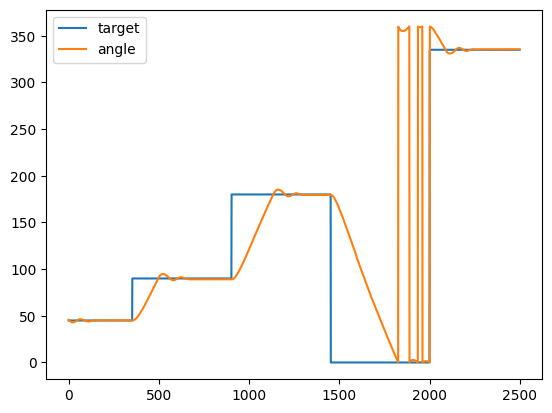

In [2]:
df = pd.read_csv('data.csv', names=('target', 'angle', 'error', 'gain'))
df[['target', 'angle']][:2500].plot()

In [50]:
%%writefile servo_controller.py
import time
from machine import Pin, PWM, SPI

cs = Pin(5, mode=Pin.OUT, value=1)
spi = SPI(0, baudrate=1_000_000, sck=Pin(6), mosi=Pin(7), miso=Pin(4), firstbit=SPI.MSB)

motor_a = PWM(Pin(16, mode=Pin.OPEN_DRAIN, value=1))
motor_b = PWM(Pin(17, mode=Pin.OPEN_DRAIN, value=1))

motor_a.duty_u16(0)
motor_b.duty_u16(0)


def decode_angle(data):
    
    raw_data = (data[0] << 6) | (data[1] >> 2)
    angle_norm = (raw_data / 8192) - 1
    angle_degr = angle_norm * 360
    
    status_bits = (data[1] & 0b11) | (data[2] >> 6)
    crc = data[2] & 0b111111
    
    status_str = 'loss_track ' if status_bits & 0b1000 else '- '
    status_str += 'push ' if status_bits & 0b100 else 'no_push '
    
    if status_bits & 0b11 == 0:
        status_str += 'normal'
    elif status_bits & 0b11 == 1:
        status_str += 'strong'
    elif status_bits & 0b11 == 2:
        status_str += 'weak'
    else:
        status_str += '-'
    
    return angle_degr, status_bits, status_str, crc


def get_angle():
    cs.off()
    data = spi.read(3)
    cs.on()
    
    angle, _, _, _ = decode_angle(data)
    return angle


def shortest_angle(current_angle, target_angle):
    return (target_angle - current_angle + 540) % 360 - 180


def set_move_ccw(gain):
    motor_a.duty_u16(gain)
    motor_b.duty_u16(0)
    

def set_move_cw(gain):
    motor_a.duty_u16(0)
    motor_b.duty_u16(gain)
    

def set_no_move():
    motor_a.duty_u16(0)
    motor_b.duty_u16(0)
    

# Move to start
while get_angle() > 0.5:
    set_move_ccw(20_000)
    
set_no_move()

time.sleep_ms(500)

initial_deadline = time.ticks_add(time.ticks_ms(), 2500)
deadline = time.ticks_add(time.ticks_ms(), 6000)

target = 45

dt_us = 100
dt_s = dt_us / 1_000_000

prev_error = 0
    
while True:
    if time.ticks_diff(deadline, time.ticks_ms()) <= 0:
        break
        
    if time.ticks_diff(initial_deadline, time.ticks_ms()) <= 0:
        target = 180
    
    angle = get_angle()
    
    error = shortest_angle(angle, target)
    error_norm = (abs(error) / 360)
    
    error_delta = (error_norm - prev_error) / dt_s
    prev_error = error_norm
    
    Kp = 2
    Kd = 0.005
    
    if abs(target - angle) > 0.5:
        gain = 0.25 + Kp*error_norm + Kd*error_delta
        if gain >= 1:
            gain = 1
        
        duty_u16 = int(gain * 65535)
        
        if error > 0:
            set_move_ccw(duty_u16)
        else:
            set_move_cw(duty_u16)
    else:
        set_no_move()
        
    print(f'{target},{angle},{error},{gain}')
    
    time.sleep_us(dt_us)

Overwriting servo_controller.py


In [51]:
pyb = pyboard.Pyboard('/dev/tty.usbmodem1101')
pyb.enter_raw_repl()

output = pyb.execfile('servo_controller.py')

pyb.exit_raw_repl()
pyb.close()

Text(0, 0.5, 'Angle (degrees)')

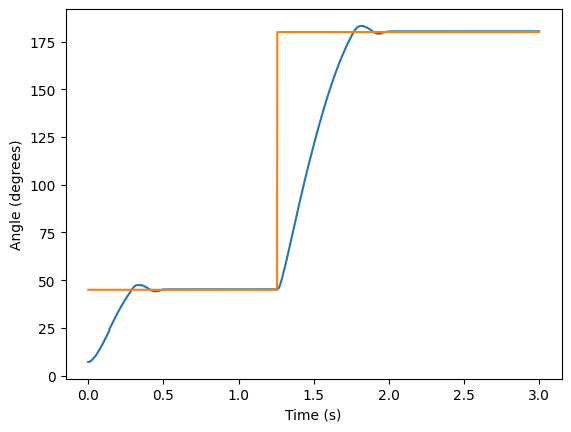

In [52]:
%matplotlib inline

import csv
import numpy as np
import matplotlib.pyplot as plt

target = []
angle = []
error = []
gain = []

for row in output.decode('utf-8').split('\r\n')[:-1]:
    values = row.split(',')
    target.append(float(values[0]))
    angle.append(float(values[1]))
    error.append(float(values[2]))
    gain.append(float(values[3]))

x = np.linspace(0, 3, len(target))
    
fig, ax = plt.subplots()
ax.plot(x, angle)
ax.plot(x, target)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (degrees)')

In [63]:
%%writefile servo_controller.py
import time
from machine import Pin, PWM, SPI

cs = Pin(5, mode=Pin.OUT, value=1)
spi = SPI(0, baudrate=1_000_000, sck=Pin(6), mosi=Pin(7), miso=Pin(4), firstbit=SPI.MSB)

motor_a = PWM(Pin(16, mode=Pin.OPEN_DRAIN, value=1))
motor_b = PWM(Pin(17, mode=Pin.OPEN_DRAIN, value=1))

motor_a.duty_u16(0)
motor_b.duty_u16(0)


def decode_angle(data):
    raw_data = (data[0] << 6) | (data[1] >> 2)
    angle_norm = (raw_data / 8192) - 1
    angle_degr = angle_norm * 360
    
    status_bits = (data[1] & 0b11) | (data[2] >> 6)
    crc = data[2] & 0b111111
    
    status_str = 'loss_track ' if status_bits & 0b1000 else '- '
    status_str += 'push ' if status_bits & 0b100 else 'no_push '
    
    if status_bits & 0b11 == 0:
        status_str += 'normal'
    elif status_bits & 0b11 == 1:
        status_str += 'strong'
    elif status_bits & 0b11 == 2:
        status_str += 'weak'
    else:
        status_str += '-'
    
    return angle_degr, status_bits, status_str, crc


def get_angle():
    cs.off()
    data = spi.read(3)
    cs.on()
    
    angle, _, _, _ = decode_angle(data)
    return angle


def set_move_ccw(gain):
    motor_a.duty_u16(gain)
    motor_b.duty_u16(0)
    

def set_move_cw(gain):
    motor_a.duty_u16(0)
    motor_b.duty_u16(gain)
    

def set_no_move():
    motor_a.duty_u16(0)
    motor_b.duty_u16(0)
    

# Move to start
while get_angle() > 0.5:
    set_move_ccw(20_000)
    
set_no_move()

time.sleep_ms(500)

deadline = time.ticks_add(time.ticks_ms(), 30 * 1000)

revs = 0
prev_angle = 0

# Max duty cycle
set_move_ccw(65500)
    
while True:
    if time.ticks_diff(deadline, time.ticks_ms()) <= 0:
        break
    
    angle = get_angle()
    
    if angle < prev_angle:
        revs += 1
    
    prev_angle = angle
    
    time.sleep_us(100)
    
print(revs)

Overwriting servo_controller.py


In [64]:
pyb = pyboard.Pyboard('/dev/tty.usbmodem1101')
pyb.enter_raw_repl()

output = pyb.execfile('servo_controller.py')

pyb.exit_raw_repl()
pyb.close()

print(output)

# 22 revs in 30 seconds => 44 RPM

b'0\r\n'
